https://machinelearningmastery.com/clustering-algorithms-with-python/
<br> https://www.geeksforgeeks.org/ml-fuzzy-clustering/
<br> https://fuzzy-c-means.readthedocs.io/en/latest/examples/00%20-%20Basic%20clustering/
<br> https://umap-learn.readthedocs.io/en/latest/transform.html

# install pakages 

In [1]:
# !pip install umap-learn


# Imports 

In [2]:

# general
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
import itertools
import pandas as pd

# projection
from sklearn.manifold import TSNE

# tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# metrics 
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix


# Part 0) - Generate datasets


## Part 0) - set seed

In [3]:
random_state = 42
np.random.seed(random_state)

## Part 0.1.1) define dataset1
* class 1 generated from standard normal with 2 mean
* class 0 generated from standard normal with 0 mean


In [4]:

# Dataset 1
num_samples_1 = 200
# generate positive exampels 
negative_features = np.random.randn(num_samples_1, 10) 
mean = 2
positive_features = np.random.randn(num_samples_1, 10) +  mean

dataset1_all_features  =  np.concatenate([negative_features, positive_features])
dataset1_labels  =  np.concatenate([np.zeros((num_samples_1,1)), np.ones((num_samples_1,1))])




## Part 0.2.1) split dataset into train&test

In [5]:
x1_train, x1_test, y1_train, y1_test = train_test_split(dataset1_all_features, dataset1_labels, test_size=0.1, random_state=random_state)


## Part 0.3.1) project dataset1 into 2D and visualized  

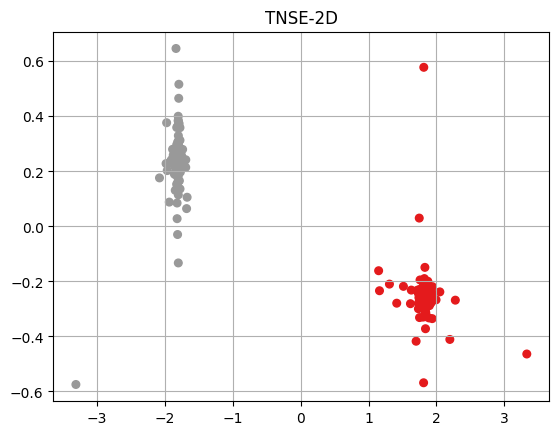

In [6]:

# set model 
TSNE_model = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=10, n_iter= 250)

# train model
projection = TSNE_model.fit_transform(dataset1_all_features)


plt.figure()
plt.title('TNSE-2D')
plt.scatter(projection[:, 0], projection[:, 1], c=dataset1_labels, s=30, cmap='Set1')
plt.grid()
plt.show()

## Part 0.1.2) define dataset1
* class 1 generated from point outside to sphere with radius 5
* class 0 generated from point inside  to sphere with radius 5

In [7]:

# Number of samples
num_samples = 200

# Sphere parameters
radius = 5.0
center = np.array([0, 0, 0])

# Generate points inside the sphere
inside_points = np.random.normal(size=(num_samples, 3))
inside_points /= np.linalg.norm(inside_points, axis=1, keepdims=True)  # Normalize vectors
inside_points *= radius  # Scale by the radius
inside_points += center  # Translate to the center of the sphere

# Generate points outside the sphere
outside_points = np.random.normal(size=(num_samples, 3))
outside_points /= np.linalg.norm(outside_points, axis=1, keepdims=True)  # Normalize vectors
outside_points *= radius + 1  # Scale by a factor larger than the radius
outside_points += center  # Translate to the center of the sphere

# combine points
all_features = np.concatenate([inside_points, inside_points])
dataset2_all_features = np.float32(all_features)
dataset2_labels  =  np.concatenate([np.zeros((num_samples,1)), np.ones((num_samples,1))])



## Part 0.2.2) split dataset into train&test

In [8]:
x2_train, x2_test, y2_train, y2_test = train_test_split(dataset2_all_features, dataset2_labels, test_size=0.1, random_state=random_state)


## Part 0.3.2) visualized dataset

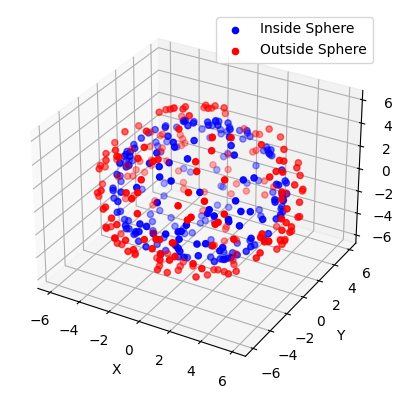

In [9]:

# Plotting the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inside_points[:, 0], inside_points[:, 1], inside_points[:, 2], c='b', label='Inside Sphere')
ax.scatter(outside_points[:, 0], outside_points[:, 1], outside_points[:, 2], c='r', label='Outside Sphere')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# Part 1: Gradient Boosting Regression Trees (GBRT)

## 4) Implement GRBT


In [56]:

class Gradient_Boosting_Regressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.initial_pred = 0.0
        self.MSE_list = []
    # 4a) calcualate loss function
    def calculate_mse(self, residuals):
        mse = 0.5*np.mean((residuals) ** 2)
        return mse
    
    def generate_initial_pred(self, y):
        self.initial_pred = np.mean(y)
        self.predictions = np.tile(self.initial_pred, (y.shape[0], 1))
        
        
    def fit(self, X, y):
        
        # generate initial prediction
        self.generate_initial_pred(y)

        # 4b) calculate residual
        residuals  = y-self.predictions
        
        for _ in range(self.n_estimators):
            
           
            # 4a) calcualate loss function
            loss =  self.calculate_mse(residuals)
            
            # 4c) weak regression tree 
            # Fit a regression tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            
            # Compute the predictions from the tree
            residual_prediction = tree.predict(X)
            
            # 4d) boosting step
            # Update the residuals by subtracting the predictions
            residuals -= self.learning_rate * np.expand_dims(residual_prediction, axis=1)
            
            # Add the tree to the list of estimators
            self.estimators.append(tree)

            # append Mse loss
            self.MSE_list.append(loss)

    def predict(self, X):
        # Initialize the predictions with the initial_pred
        predictions = self.initial_pred * np.ones(X.shape[0])
        
        # Make predictions using each estimator
        for tree in self.estimators:
            predictions += self.learning_rate * tree.predict(X)
        
        return predictions

#### prepare simulations

In [60]:
def generate_GRBT_expirements():
    lr = [1e-3,1e-2,1e-1]
    n_estimators = [50,100,150]
    max_depth =  [1,2,3,4,5]
    
    all_combinations  = [lr, n_estimators, max_depth]
    all_combinations = list(itertools.product(*all_combinations))
    return all_combinations

results_columns_names = ['expirement_name','lr', 'n_estimators','max_depth', 'train_loss', 'test_loss']

GRBT_combination = generate_GRBT_expirements()


#### run sumulation on dataset1

In [61]:

expirements_results  = []
mse_expirements_results  = []

for (lr, n_estimators, max_depth) in GRBT_combination:
    
    results = []

    # set model
    gradient_boosting_classifier = Gradient_Boosting_Regressor(n_estimators = n_estimators , learning_rate =lr, max_depth=max_depth)

    # train model
    gradient_boosting_classifier.fit(x1_train, y1_train)
    
    # get loss decreesing list
    MSE_list = gradient_boosting_classifier.MSE_list
    
    # predict train labels
    y_train_pred =  gradient_boosting_classifier.predict(x1_train)

    # predict test labels
    y_test_pred =  gradient_boosting_classifier.predict(x1_test)

    # set expirement name 
    name = 'lr_' + str(lr) + '_n_estimators_' + str(n_estimators) + '_max_depth_' + str(max_depth) 
    
    # append training loss as function of estimator
    mse_expirements_results.append([name, MSE_list])

    # append parameters 
    results += [name, lr, n_estimators, max_depth]
    
    # calculate metric and loss
    train_loss =  gradient_boosting_classifier.calculate_mse(y1_train-y_train_pred)
    test_loss =  gradient_boosting_classifier.calculate_mse(y1_test-y_test_pred)

    # append metric\loss results 
    results += [ train_loss, test_loss]

    expirements_results.append(results)
    
# clusters metric
df = pd.DataFrame(expirements_results, columns = results_columns_names)
df = df.sort_values('test_loss', ascending = True)

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

In [62]:
df = df.sort_values('train_loss', ascending = True)
df[0:100]

,expirement_name,lr,n_estimators,max_depth,train_loss,test_loss
0,lr_0.001_n_estimators_50_max_depth_1,0.001,50,1,0.125169,0.125283
1,lr_0.001_n_estimators_50_max_depth_2,0.001,50,2,0.125229,0.125345
2,lr_0.001_n_estimators_50_max_depth_3,0.001,50,3,0.125273,0.125392
3,lr_0.001_n_estimators_50_max_depth_4,0.001,50,4,0.125290,0.125428
4,lr_0.001_n_estimators_50_max_depth_5,0.001,50,5,0.125294,0.125433
5,lr_0.001_n_estimators_100_max_depth_1,0.001,100,1,0.125552,0.125705
6,lr_0.001_n_estimators_100_max_depth_2,0.001,100,2,0.125876,0.126027
7,lr_0.001_n_estimators_100_max_depth_3,0.001,100,3,0.126035,0.126146
8,lr_0.001_n_estimators_100_max_depth_4,0.001,100,4,0.126117,0.126282
9,lr_0.001_n_estimators_100_max_depth_5,0.001,100,5,0.126129,0.126299


##### get best results parameters

In [63]:
lr, n_estimators, max_depth  = df.iloc[0][['lr', 'n_estimators','max_depth']].to_list() 
print(f'best parameters:\n1) lr = {lr}\n2) n_estimators = {n_estimators}\n3) max_depth = {max_depth}')

best parameters:
1) lr = 0.001
2) n_estimators = 50
3) max_depth = 1


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


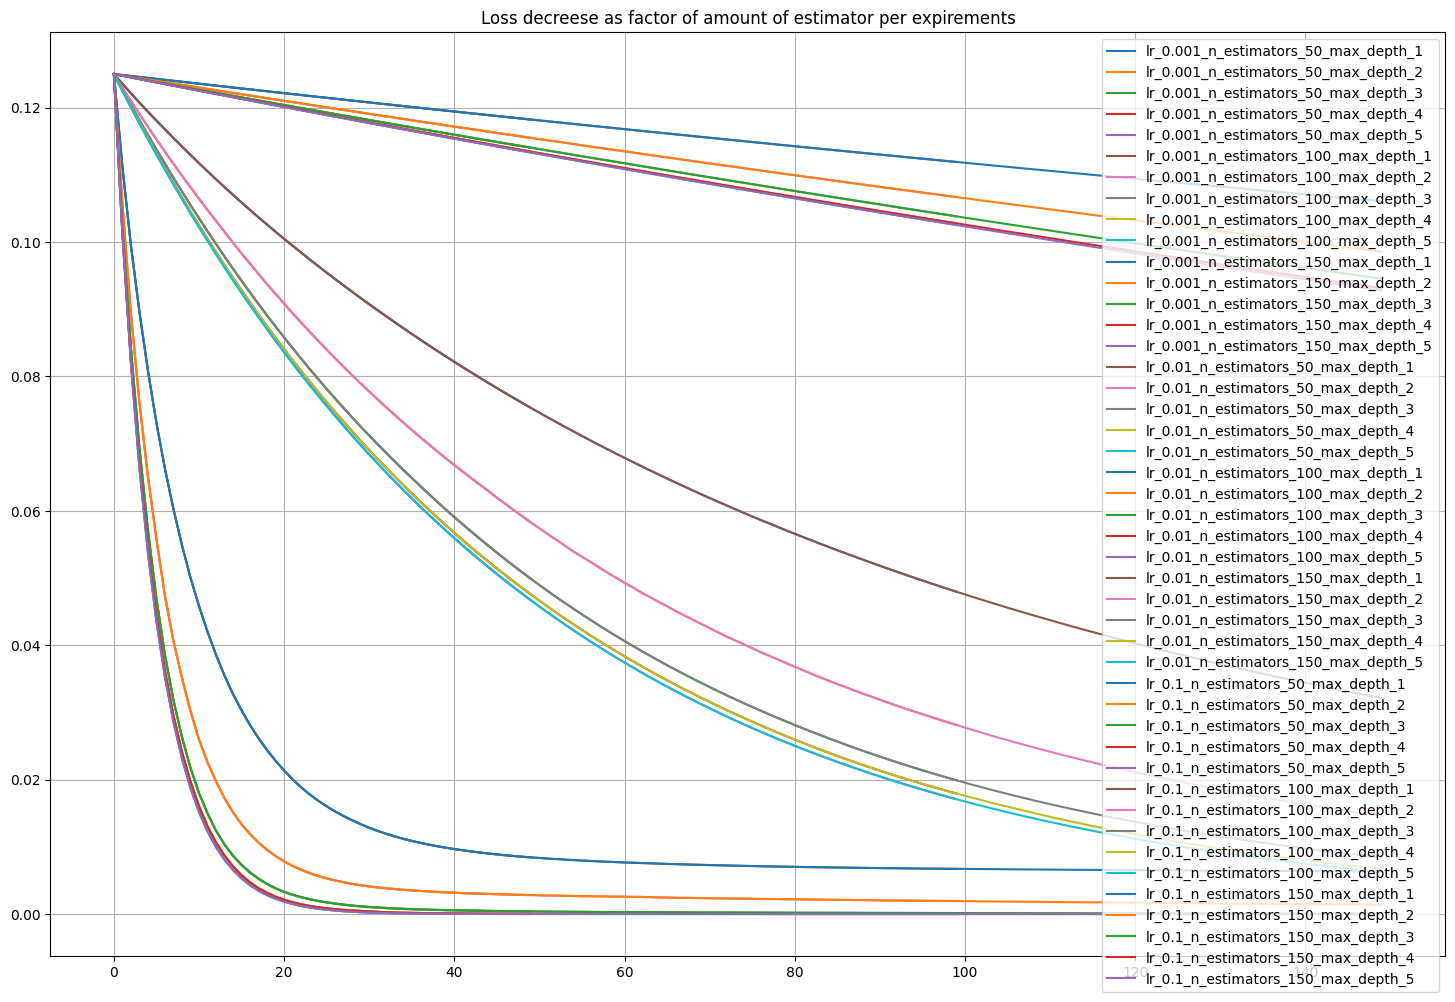

In [64]:
plt.figure(figsize = (18,12))
for expirement_name, expirements_mse_list in mse_expirements_results:
   plt.plot(np.arange(expirements_mse_list.__len__()), expirements_mse_list, label =expirement_name )
plt.grid()
plt.title('Loss decreese as factor of amount of estimator per expirements')
plt.legend()

##### Compare Sklearn implemnentation

In [66]:
reg = GradientBoostingRegressor(learning_rate =1e-3 ,n_estimators =50 , max_depth =1 ,  random_state=0)
reg.fit(x1_train, y1_train)
y_pred_test = reg.predict(x1_test)
mse_sklearn_implementation = gradient_boosting_classifier.calculate_mse(y1_test-y_pred_test)
print('f slearn implemetation achieve with our parameter MSE - {mse_sklearn_implementation}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1252831957735052

#### run sumulation on dataset2

In [ ]:

expirements_results  = []
mse_expirements_results  = []

for (lr, n_estimators, max_depth) in GRBT_combination:
    
    results = []

    # set model
    gradient_boosting_classifier = Gradient_Boosting_Regressor(n_estimators = n_estimators , learning_rate =lr, max_depth=max_depth)

    # train model
    gradient_boosting_classifier.fit(x2_train, y2_train)
    
    # get loss decreesing list
    MSE_list = gradient_boosting_classifier.MSE_list
    
    # predict train labels
    y_train_pred =  gradient_boosting_classifier.predict(x2_train)

    # predict test labels
    y_test_pred =  gradient_boosting_classifier.predict(x2_test)

    # set expirement name 
    name = 'lr_' + str(lr) + '_n_estimators_' + str(n_estimators) + '_max_depth_' + str(max_depth) 
    
    # append training loss as function of estimator
    mse_expirements_results.append([name, MSE_list])

    # append parameters 
    results += [name, lr, n_estimators, max_depth]
    
    # calculate metric and loss
    train_loss =  gradient_boosting_classifier.calculate_mse(y2_train-y_train_pred)
    test_loss =  gradient_boosting_classifier.calculate_mse(y2_test-y_test_pred)

    # append metric\loss results 
    results += [ train_loss, test_loss]

    expirements_results.append(results)
    
# clusters metric
df = pd.DataFrame(expirements_results, columns = results_columns_names)
df = df.sort_values('test_loss', ascending = True)

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

In [ ]:
df = df.sort_values('train_loss', ascending = True)
df[0:50]

,expirement_name,lr,n_estimators,max_depth,train_loss,test_loss
0,lr_1e-05_n_estimators_50_max_depth_1,0.00001,50,1,0.124996,0.125073
1,lr_1e-05_n_estimators_50_max_depth_2,0.00001,50,2,0.124996,0.125073
2,lr_1e-05_n_estimators_50_max_depth_3,0.00001,50,3,0.124996,0.125073
5,lr_1e-05_n_estimators_100_max_depth_1,0.00001,100,1,0.124996,0.125074
3,lr_1e-05_n_estimators_50_max_depth_4,0.00001,50,4,0.124996,0.125073
6,lr_1e-05_n_estimators_100_max_depth_2,0.00001,100,2,0.124996,0.125073
4,lr_1e-05_n_estimators_50_max_depth_5,0.00001,50,5,0.124996,0.125073
10,lr_1e-05_n_estimators_150_max_depth_1,0.00001,150,1,0.124996,0.125074
7,lr_1e-05_n_estimators_100_max_depth_3,0.00001,100,3,0.124996,0.125073
11,lr_1e-05_n_estimators_150_max_depth_2,0.00001,150,2,0.124996,0.125073


##### get best results parameters

In [ ]:
lr, n_estimators, max_depth  = df.iloc[0][['lr', 'n_estimators','max_depth']].to_list() 
print(f'best parameters:\n1) lr = {lr}\n2) n_estimators = {n_estimators}\n3) max_depth = {max_depth}')

best parameters:
1) lr = 1e-05
2) n_estimators = 50
3) max_depth = 1


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


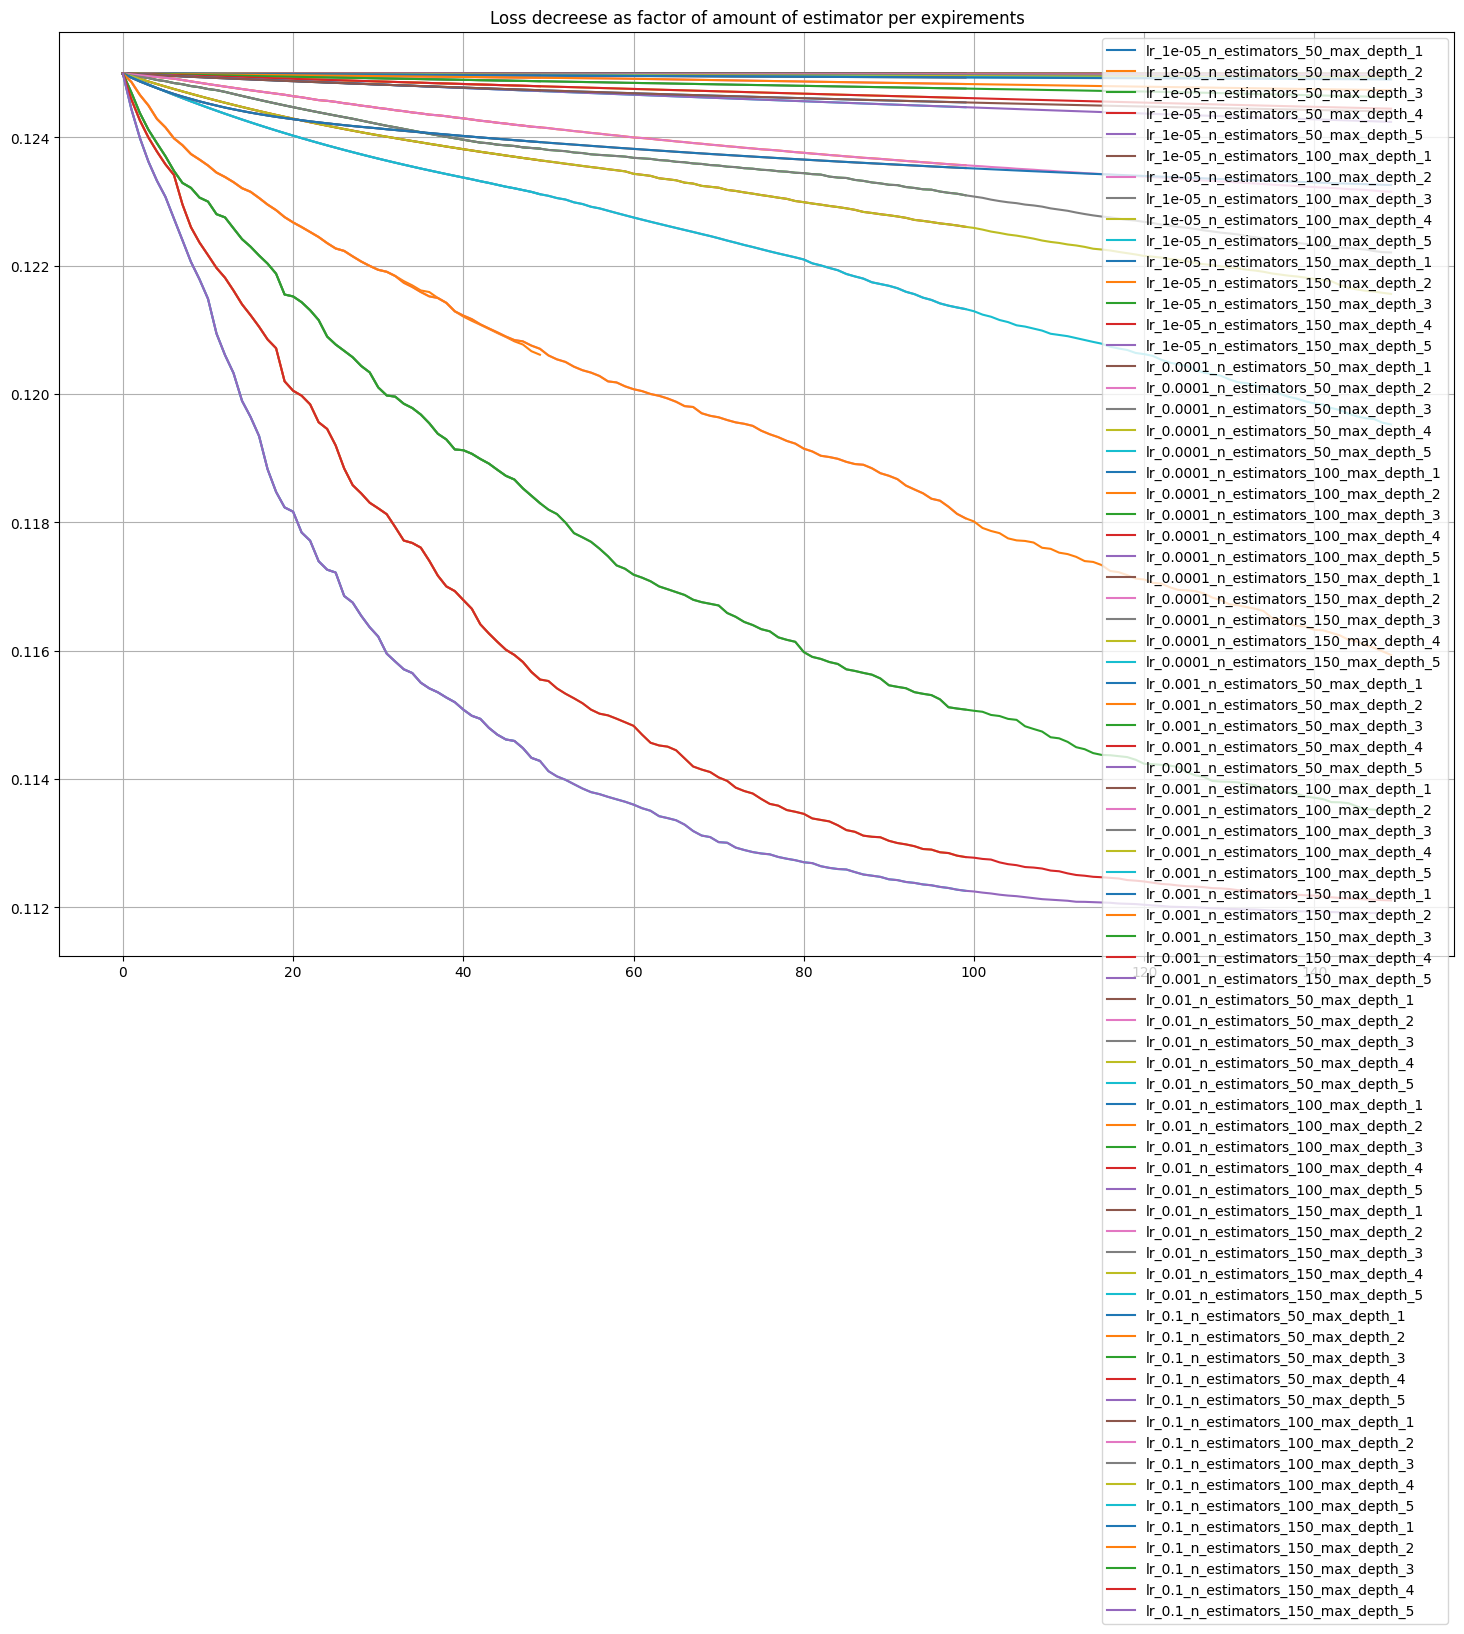

In [ ]:
plt.figure(figsize = (18,12))
for expirement_name, expirements_mse_list in mse_expirements_results:
   plt.plot(np.arange(expirements_mse_list.__len__()), expirements_mse_list, label =expirement_name )
plt.grid()
plt.title('Loss decreese as factor of amount of estimator per expirements')
plt.legend()

##### Compare Sklearn implemnentation

In [ ]:
reg = GradientBoostingRegressor(learning_rate =1e-3 ,n_estimators =50 , max_depth =1 ,  random_state=0)
reg.fit(x2_train, y2_train)
y_pred_test = reg.predict(x2_test)
mse_sklearn_implementation = gradient_boosting_classifier.calculate_mse(y2_test-y_pred_test)
print('f slearn implemetation achieve with our parameter MSE - {mse_sklearn_implementation}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1252831957735052

# Part 2: AdaBoost

## 4) Implement adaboost


In [29]:
def evaluate(true_labels, predicted_labels, model_name = "model", conf_mat = True, print_res=True):
    accuracy = accuracy_score(y1_train, y_train_pred)
    if print_res:
        print(f'{model_name} accuracy on {len(predicted_labels)} test images: {accuracy*100:.2f}%')

    if conf_mat:
        mat = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.title("confusion matrix")
        plt.show()
    
    return accuracy



class Ada_Boost_Classifier:
    def __init__(self, num_estimators, uniform_weight  = True):
        # size of forest
        self.num_estimators = num_estimators
        # list of stumps 
        self.estimators_list = []
        # list of amount of say 
        self.importance_weight_list = []
        
        self.uniform_weight = uniform_weight

        self.accuracy_list = [] 
    def generate_weights(self, n):
        """
        generate equal vote for each sample 
        """
        if self.uniform_weight:
            sample_weights = np.full(n, 1 / n)
        else:
            sample_weights = np.full(n, 1 / n)
        return sample_weights.reshape(-1, 1)
    
    
    def update_weights(self, importance_weight, sample_weights, model_error, predictions, y):
        # 7e) boosting step
        temp_ones = np.ones_like(sample_weights)
        temp_ones[np.squeeze(y) ==predictions] = -1
        sample_weights *= np.exp(importance_weight * temp_ones.T).T
        # 7f) update weight
        sample_weights /= np.sum(sample_weights)
        return sample_weights
    
    
    def calculate_step_size(self, model_error):
        # calculate 
        importance_weight = 0.5 * np.log((1 - model_error) / model_error)
        
        
        return importance_weight
    
    
    def fit(self, X, y):
        # amount of sampels
        n = X.shape[0]
        
        # 7a
        sample_weights = self.generate_weights(n)
        index_array = np.arange(n)
        for _ in range(self.num_estimators):
            try:
                # 7b -generate decision stump
                estimator = DecisionTreeClassifier(max_depth=1)
                
                sample_index = [np.random.choice(index_array, p=np.squeeze(sample_weights)) for _ in range(n)]
                
                train_dataset = X[sample_index]
                y_dataset = y[sample_index]

                # train decision stump
                trained_estimator = estimator.fit(train_dataset, y_dataset)
                
                predictions = trained_estimator.predict(train_dataset)
                sample_weights = self.generate_weights(n)

                # 7c) calculate model train errors
                model_error = np.sum(sample_weights.T * (predictions != y_dataset.T))
                
                # 7d) calculate step size - alpha 
                importance_weight = self.calculate_step_size(model_error)
                
                # 7-e+f) calculate new weight after current tree predicitons
                sample_weights = self.update_weights(importance_weight,sample_weights, 
                                                     model_error, predictions, y_dataset)
                
                # append current stump
                self.estimators_list.append(trained_estimator)
                
                # append calculated 
                self.importance_weight_list.append(importance_weight)

                y_pred =  ada_boost_classifier.predict(X)
                training_accuracy_score = accuracy_score(y, y_pred)
                self.accuracy_list.append(training_accuracy_score)
            except:
                a=5

    def predict(self, X):
        
        # initilized perdiciton as factor of amount of sampels
        predictions = np.zeros(X.shape[0])
        
        # run prediction over all stumps trre's
        for estimator, importance_weight in zip(self.estimators_list, self.importance_weight_list):
            
            # prediction steps
            curr_predictions = estimator.predict(X)
            curr_predictions[curr_predictions==0]=-1
            predictions += importance_weight * curr_predictions
    
        predictions[predictions>=0] = 1            
        predictions[predictions<0] = 0
        

        return predictions


#### prepare simulations

In [37]:
def generate_adaboost_expirements():
    # lr = [1e-5,1e-4,1e-3,1e-2,1e-1]
    n_estimators = [5,10,15,30,50,100,200,500,1000]
    
    all_combinations  = [n_estimators]
    all_combinations = list(itertools.product(*all_combinations))
    return all_combinations

results_columns_names = ['expirement_name', 'n_estimators', 'train_accuracy', 'test_accuracy']

adaboost_combination = generate_adaboost_expirements()


#### run sumulation on dataset1

In [38]:

expirements_results  = []
accuracy_expirements_results  = []

for n_estimators in adaboost_combination:
    n_estimators=n_estimators[0]
    results = []

    # set model
    ada_boost_classifier = Ada_Boost_Classifier(num_estimators = n_estimators)

    # train model
    ada_boost_classifier.fit(x1_train, y1_train)


    # get loss decreesing list
    accuracy_list =  ada_boost_classifier.accuracy_list

    # predict train labels
    y_train_pred =  ada_boost_classifier.predict(x1_train)

    # predict test labels
    y_test_pred =  ada_boost_classifier.predict(x1_test)

    # set expirement name 
    name = 'n_estimators_' + str(n_estimators) 
    
    # append training loss as function of estimator
    accuracy_expirements_results.append([name, accuracy_list])

    # append parameters 
    results += [name, n_estimators]
    
    # calculate metric and loss
    train_accuracy =  accuracy_score(y1_train, y_train_pred)
    test_accuracy =  accuracy_score(y1_test,y_test_pred)

    # append metric\loss results 
    results += [ train_accuracy, test_accuracy]

    expirements_results.append(results)
    
# clusters metric
df = pd.DataFrame(expirements_results, columns = results_columns_names)
df = df.sort_values('test_accuracy', ascending = False)

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

In [39]:
df[0:50]

,expirement_name,n_estimators,train_accuracy,test_accuracy
2,n_estimators_15,15,0.966667,0.950
1,n_estimators_10,10,0.936111,0.925
3,n_estimators_30,30,0.969444,0.925
6,n_estimators_200,200,0.983333,0.925
7,n_estimators_500,500,0.986111,0.925
8,n_estimators_1000,1000,0.980556,0.925
4,n_estimators_50,50,0.966667,0.900
5,n_estimators_100,100,0.980556,0.900
0,n_estimators_5,5,0.900000,0.825


##### get best results parameters

In [44]:
n_estimators  = df.iloc[0][['n_estimators']].to_list()[0] 
print(f'best parameters: \n1) n_estimators = {n_estimators}')

best parameters: 
1) n_estimators = 15


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


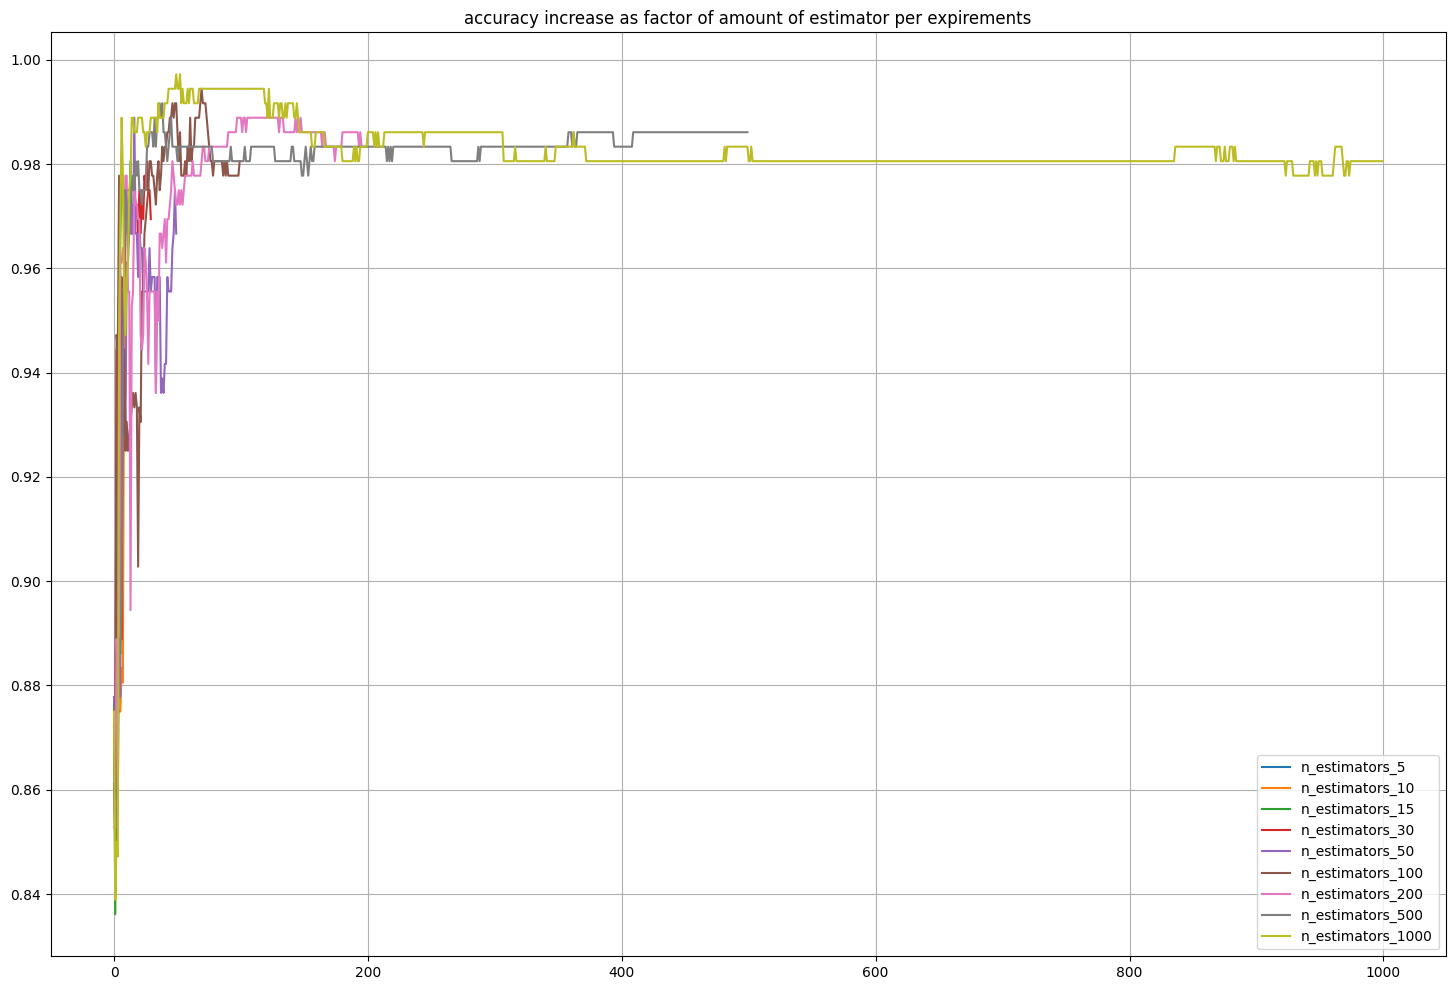

In [41]:
plt.figure(figsize = (18,12))
for expirement_name, expirements_accuracy_list in accuracy_expirements_results:
   plt.plot(np.arange(expirements_accuracy_list.__len__()), expirements_accuracy_list, label =expirement_name )
plt.grid()
plt.title('accuracy increase as factor of amount of estimator per expirements')
plt.legend()

##### diplay confusion matrix

model accuracy on 40 test images: 98.06%


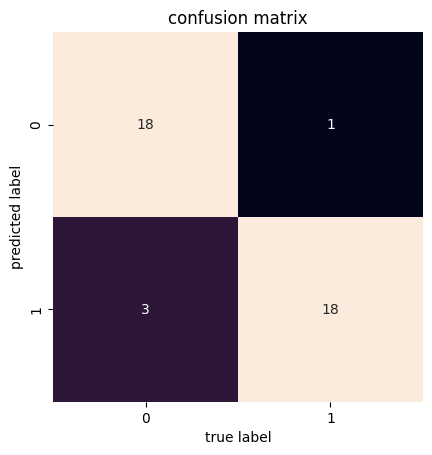

0.9805555555555555

In [47]:
# set model
ada_boost_classifier = Ada_Boost_Classifier(num_estimators = n_estimators)

# train model
ada_boost_classifier.fit(x1_train, y1_train)


# get loss decreesing list
accuracy_list =  ada_boost_classifier.accuracy_list

# predict train labels
y_test_pred =  ada_boost_classifier.predict(x1_test)


evaluate(y1_test, y_test_pred, model_name = "model", conf_mat = True, print_res=True)

##### comapre to sklearn implementation

model accuracy on 40 test images: 52.50%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


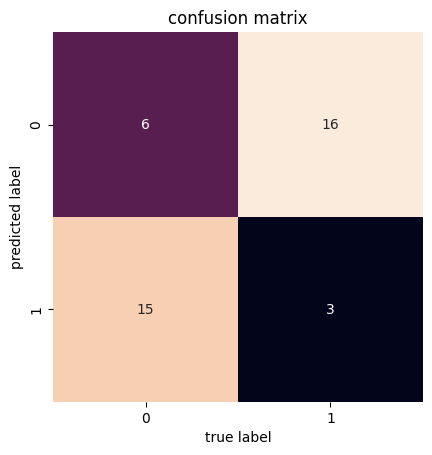

0.525

In [ ]:
clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
clf.fit(x1_train.tolist(), y1_train.tolist())
y_test_pred = clf.predict(x1_test.tolist())
accuracy = evaluate(y1_test, y_test_pred, model_name = "model", conf_mat = True, print_res=True)

#### comapre to sklearn implementation

#### run sumulation on dataset1

In [48]:

expirements_results  = []
accuracy_expirements_results  = []

for n_estimators in adaboost_combination:
    n_estimators=n_estimators[0]
    results = []

    # set model
    ada_boost_classifier = Ada_Boost_Classifier(num_estimators = n_estimators)

    # train model
    ada_boost_classifier.fit(x2_train, y2_train)


    # get loss decreesing list
    accuracy_list =  ada_boost_classifier.accuracy_list

    # predict train labels
    y_train_pred =  ada_boost_classifier.predict(x2_train)

    # predict test labels
    y_test_pred =  ada_boost_classifier.predict(x2_test)

    # set expirement name 
    name = 'n_estimators_' + str(n_estimators) 
    
    # append training loss as function of estimator
    accuracy_expirements_results.append([name, accuracy_list])

    # append parameters 
    results += [name, n_estimators]
    
    # calculate metric and loss
    train_accuracy =  accuracy_score(y2_train, y_train_pred)
    test_accuracy =  accuracy_score(y2_test,y_test_pred)

    # append metric\loss results 
    results += [ train_accuracy, test_accuracy]

    expirements_results.append(results)
    
# clusters metric
df = pd.DataFrame(expirements_results, columns = results_columns_names)
df = df.sort_values('test_accuracy', ascending = False)

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

In [49]:
df[0:50]

,expirement_name,n_estimators,train_accuracy,test_accuracy
2,n_estimators_15,15,0.505556,0.450
4,n_estimators_50,50,0.505556,0.450
0,n_estimators_5,5,0.508333,0.425
1,n_estimators_10,10,0.511111,0.400
5,n_estimators_100,100,0.516667,0.350
3,n_estimators_30,30,0.522222,0.300
6,n_estimators_200,200,0.522222,0.300
8,n_estimators_1000,1000,0.525000,0.275
7,n_estimators_500,500,0.527778,0.250


In [50]:
n_estimators  = df.iloc[0][['n_estimators']].to_list()[0] 
print(f'best parameters: \n1) n_estimators = {n_estimators}')

best parameters: 
1) n_estimators = 15


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


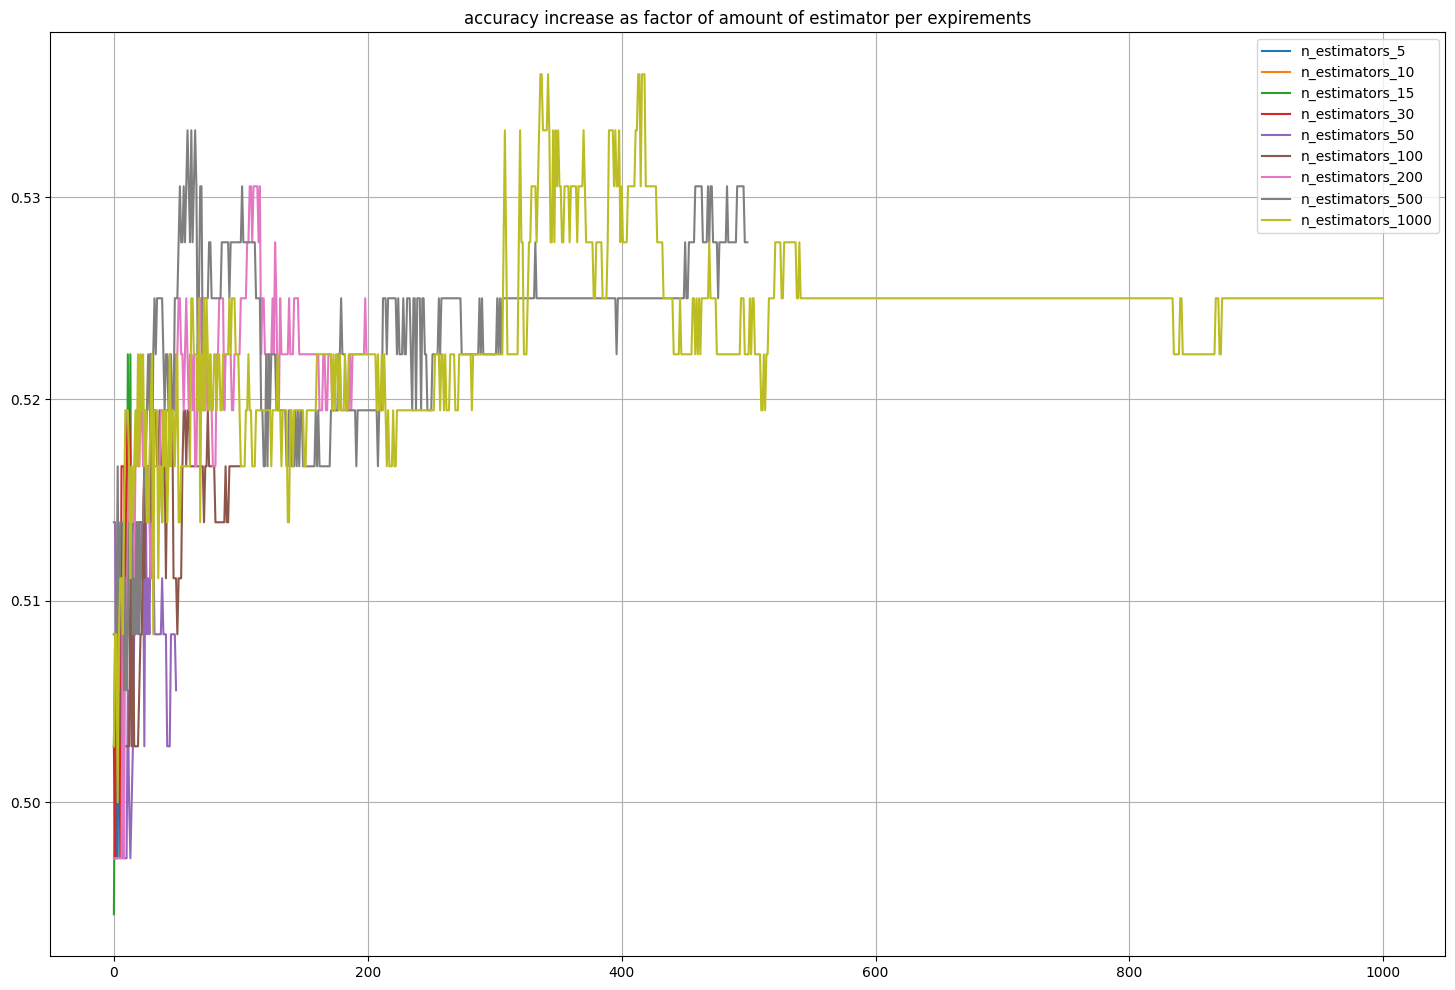

In [51]:
plt.figure(figsize = (18,12))
for expirement_name, expirements_accuracy_list in accuracy_expirements_results:
   plt.plot(np.arange(expirements_accuracy_list.__len__()), expirements_accuracy_list, label =expirement_name )
plt.grid()
plt.title('accuracy increase as factor of amount of estimator per expirements')
plt.legend()

##### diplay confusion matrix

model accuracy on 40 test images: 52.50%


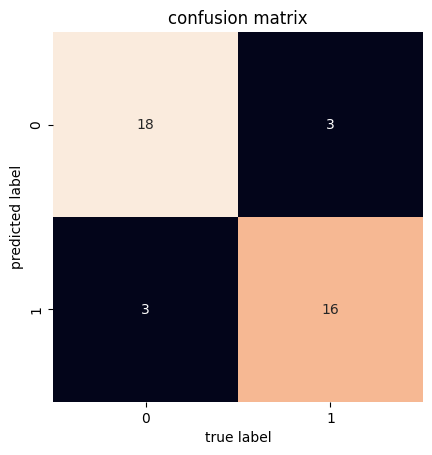

0.525

In [55]:
# set model
ada_boost_classifier = Ada_Boost_Classifier(num_estimators = n_estimators)

# train model
ada_boost_classifier.fit(x1_train, y1_train)


# get loss decreesing list
accuracy_list =  ada_boost_classifier.accuracy_list

# predict train labels
y_test_pred =  ada_boost_classifier.predict(x1_test)


accuracy = evaluate(y2_test, y_test_pred, model_name = "model", conf_mat = True, print_res=True)

##### comapre to sklearn implementation

model accuracy on 40 test images: 52.50%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


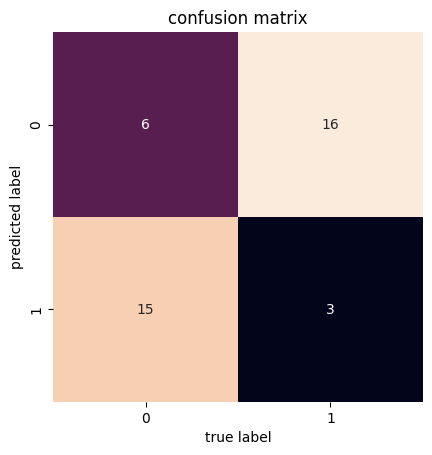

0.525

In [54]:
clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
clf.fit(x2_train.tolist(), y2_train.tolist())
y_test_pred = clf.predict(x2_test.tolist())
evaluate(y2_test, y_test_pred, model_name = "model", conf_mat = True, print_res=True)

# Part 4: Summary

## part 0 - Part 0: Load the data
* in this part we generate 2 datasets
  * first one is standard normal with 2 different mean with 10 features, with 2 different class 0/1
  * secound we define sphere, point inside the sphere is belong to class 0, and the outside point belong to class 1
* the amount of sampels is 400 overall, and the data is balanced between the class
* split data to train & test 90% fro training and 10% for testing
  * we split data base on label data in order that test data will same amount of labels per class same as in train data in order to generlized
* we visualized the dataset1 after dimention reduction due to the fact amount of feature is 10, and it is easyer to visualyzed in 2D
* we visualized dataset2 in 3D base on the dataset.



## Part 1: Gradient Boosting Regression Trees (GBRT)
* in this part we tried to use Implement GBRT
* we define our expirments, running sumulation for all combination for the following options:
  * lr = [1e-5,1e-4,1e-3,1e-2,1e-1]
  * n_estimators = [50,100,150]
  *  max_depth =  [1,2,3,4,5]
* we run the simulation on the 2 dataset we generate in part 0
* for each dataset we diplay the MSE loss as function of amount of tree's
  * it can be seen from the plot that exist parameters, which the loss decreese in monoton way, while exist parameters where after 20 trees, model is stop to be improve
* the best parameters for this sucssion is:
 * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
  * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
* for those expirements, we understand that the learning rate, is crucial for model converge for our specific data, however if was design more complex dataset maybe the amount of trees\max depth could take a place in converges of methood.
* we compare our implementation to sklearn results
  * our implementation achieve
    * dataset1 - 
    * dataset2 -
  * sklearn achieve:
    * dataset1
    * dataset2
     





## Part 2: Part 2: AdaBoost
* in this part we tried to use Implement adaboost
* we define our expirments, running sumulation for all combination for the following options:
  * n_estimators = [5,10,15,30,50,100,200,500,1000]

* we run the simulation on the 2 dataset we generate in part 0
* for each dataset we diplay the Accuracy as function of amount of tree's
  * it can be seen from the plot that exist parameters, which the accuracy increase different way, for each simulation the method enter into satoration mode in different amount of tree's
* the best parameters for this sucssion is:
 * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
  * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
* for those expirements, due to the fact we use stump as our tree, the amount of tree required for hihg accuracy results is greater than GBRT
* we compare our implementation to sklearn results
  * our implementation achieve
    * dataset1 - 
    * dataset2 -
  * sklearn achieve:
    * dataset1 - 
    * dataset2 - 


